# Deep learning Spring 2025

- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



<hr>

### **<font face="Courier New" color="blue" size="+3">Question 1: Cancerous Lesion Detection Using CNN (100 points)**



#### <font face="Verdana" color="green" size="+2">**1.1. Load dataset**




In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alizahedzadeh","key":"0120150041ca29fdc23f5c0a9abb3f25"}'}

In [2]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install -q kaggle

!kaggle datasets download -d rm1000/skin-cancer-isic-images

# Unzip the downloaded file
!unzip -q skin-cancer-isic-images.zip -d skin_cancer_dataset


Dataset URL: https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images
License(s): CC0-1.0


In [4]:
import os
os.listdir("skin_cancer_dataset")

['malignant', 'benign']

#### <font face="Verdana" color="green" size="+2">**1.2. Image Preprocessing (10 points)**




##### **1. Image Resizing**



> **Description (from paper)**: All images are resized to a consistent shape to ensure compatibility with CNN input dimensions.

> **Why it's useful**:  
- CNNs need fixed input shapes to apply convolutional filters uniformly.
- This dataset may contain images of different sizes, so resizing standardizes the input space.

> **Example**: If we choose `(128, 128)` or `(224, 224)` — standard sizes for CNNs — the network can be designed once and reused across all images.

##### **2. Normalization**

> **Description (from paper)**: Pixel values are scaled from `[0, 255]` to `[0, 1]` by dividing by 255.

> **Why it's useful**:
- Helps speed up convergence during training.
- Ensures all features (pixel values) are on the same scale.
- Reduces internal covariate shift.

##### **3. Data Augmentation**

> **Description (from paper)**: Transformations like flipping, rotating, zooming, etc., are applied.

> **Why it's useful**:
- Increases dataset size artificially.
- Improves generalization and robustness of the model.
- Prevents overfitting by exposing the model to more variations of the input.

> **Common augmentations**:
- Random flip (horizontal/vertical)
- Rotation
- Zoom
- Brightness adjustment
- Shearing

##### **4. EDA**

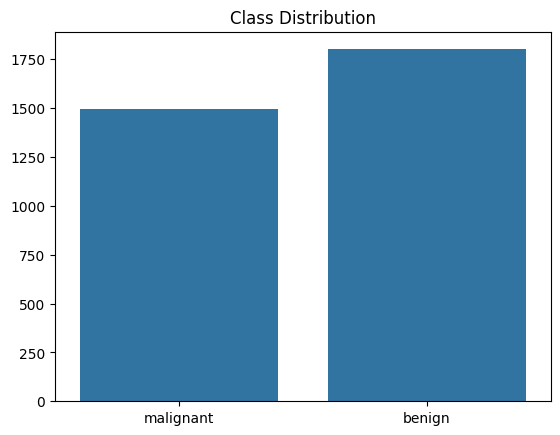

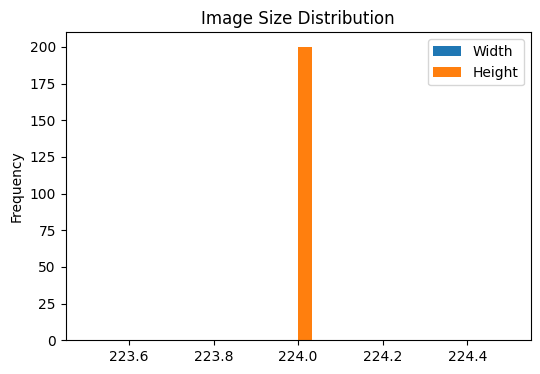

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd

# Base path
base_path = "skin_cancer_dataset"
class_names = os.listdir(base_path)

# Class distribution
counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in class_names}
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Class Distribution")
plt.show()

# Check sample image sizes
sizes = []
for cls in class_names:
    cls_folder = os.path.join(base_path, cls)
    for fname in os.listdir(cls_folder)[:100]:  # check first 100 images
        img = Image.open(os.path.join(cls_folder, fname))
        sizes.append(img.size)
        img.close()

# Plot image size distribution
size_df = pd.DataFrame(sizes, columns=["Width", "Height"])
size_df.plot(kind='hist', bins=30, title="Image Size Distribution", figsize=(6,4))
plt.show()


###### **Import libraries**

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

###### **Define data paths and get counts per class**

In [ ]:
data_dir = "skin_cancer_dataset"

classes = os.listdir(data_dir)
print("Classes:", classes)

image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
print("Image Counts per Class:", image_counts)


Classes: ['malignant', 'benign']
Image Counts per Class: {'malignant': 1497, 'benign': 1800}


###### **Visualize image distribution**

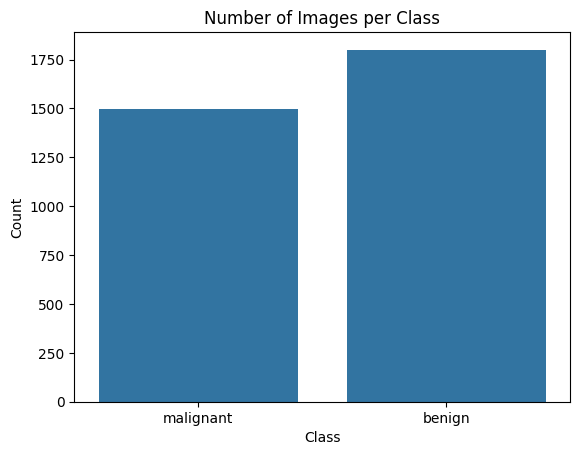

In [ ]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()


**The dataset is slightly imbalanced, but not too severe. We’ll handle it later with data augmentation or class weighting if needed.**

###### **Show sample images**

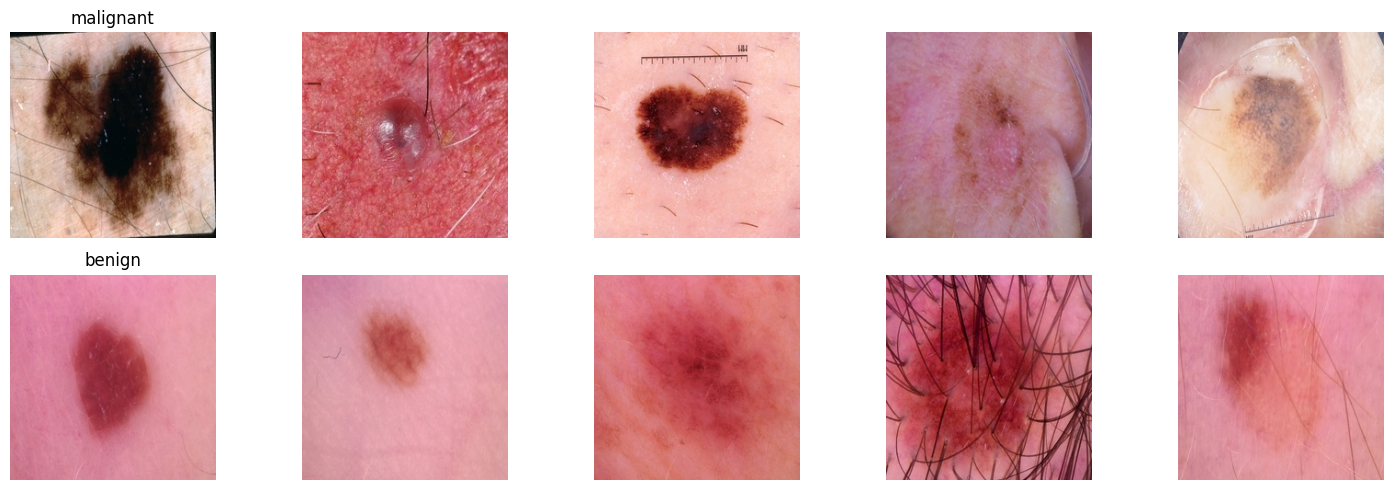

In [ ]:
def show_samples(data_dir, classes, samples_per_class=5):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 5))
    for i, cls in enumerate(classes):
        img_files = os.listdir(os.path.join(data_dir, cls))[:samples_per_class]
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(data_dir, cls, img_file)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples(data_dir, classes)


###### **Analyze image sizes (are they consistent?)**

In [ ]:
image_shapes = []

for cls in classes:
    img_files = os.listdir(os.path.join(data_dir, cls))
    for img_file in img_files[:100]:  # just sample first 100 from each to save time
        img_path = os.path.join(data_dir, cls, img_file)
        img = Image.open(img_path)
        image_shapes.append(img.size)

unique_shapes = set(image_shapes)
print("Unique image sizes found:", unique_shapes)


Unique image sizes found: {(224, 224)}


**All images have a consistent size of 224x224 → Perfect! No resizing is needed — this is already a common input size for CNNs like ResNet, VGG, etc.**

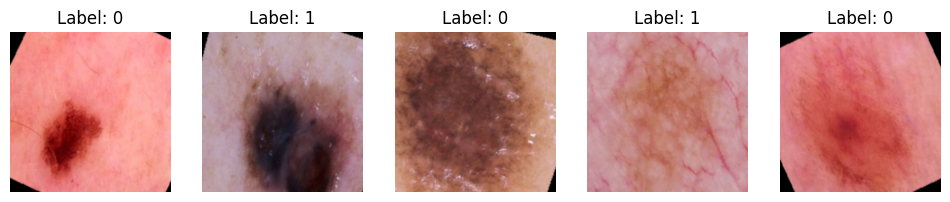

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
import matplotlib.pyplot as plt

# Define the transformation for preprocessing and data augmentation
transform = transforms.Compose([
    # Data Augmentation techniques
    transforms.RandomHorizontalFlip(),  # Flip image horizontally
    transforms.RandomRotation(30),      # Rotate image by random angles up to 30 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize image

    # Image Resizing and Normalization
    transforms.Resize(256),  # Resize to 256 to ensure proper cropping
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),  # Convert image to tensor
])

# Load the dataset
dataset = datasets.ImageFolder(root='skin_cancer_dataset', transform=transform)

# Create DataLoader for batching
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualize a batch of augmented images
def show_images(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # Convert from CHW to HWC for displaying
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

# Fetch a batch and visualize
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_images(images, labels)


#### <font face="Verdana" color="green" size="+2">**1.3. Data Augementation (10 points)**




##### **1. Why Data Augmentation is Important**

1. **Medical data is limited**  
   - It's often expensive and difficult to gather large, labeled datasets.
   - Augmentation increases data diversity without needing new images.

2. **Improves generalization**  
   - The model learns to be robust to variations like lighting, orientation, and zoom.
   - Prevents overfitting to specific features of the training images.

3. **Mimics real-world variations**  
   - Skin lesions can appear rotated, zoomed, or in different lighting conditions.
   - Augmentations simulate these scenarios.

**Recommended Augmentations for Skin Lesions**

| Augmentation      | Why it's useful                                     |
|-------------------|-----------------------------------------------------|
| `rotation_range`  | Lesions can appear at different angles              |
| `horizontal/vertical_flip` | No fixed direction for skin lesions        |
| `zoom_range`      | Mimics close-up shots or cropped lesions            |
| `shear_range`     | Adds geometric variation                            |
| `width_shift` / `height_shift` | Handles off-centered lesions         |





Data augmentation was applied to enhance model robustness and reduce overfitting. Transformations like rotation, zoom, flipping, brightness shifts, and shear were used to simulate real-world variations in skin lesion images. These augmentations help the model learn invariant features and improve generalization, especially when the dataset is moderately imbalanced or limited.

##### **2. Implementation**

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
original_dataset_dir = 'skin_cancer_dataset'  # Folder with benign/ and malignant/
base_dir = 'skin_cancer_split'

# Remove previous split (if it exists)
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Create new base directories
for split in ['train', 'val', 'test']:
    for category in ['benign', 'malignant']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Function to split and copy images with 80/10/10
def split_and_copy(class_name):
    source_dir = os.path.join(original_dataset_dir, class_name)
    all_filenames = os.listdir(source_dir)

    # Split into train (80%) and temp (20%)
    train_filenames, temp_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)

    # Split temp into val (10%) and test (10%)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

    for filename in train_filenames:
        shutil.copy(os.path.join(source_dir, filename),
                    os.path.join(base_dir, 'train', class_name, filename))

    for filename in val_filenames:
        shutil.copy(os.path.join(source_dir, filename),
                    os.path.join(base_dir, 'val', class_name, filename))

    for filename in test_filenames:
        shutil.copy(os.path.join(source_dir, filename),
                    os.path.join(base_dir, 'test', class_name, filename))

# Run for both classes
split_and_copy('benign')
split_and_copy('malignant')


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize to [0,1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

# Validation & Test data generators (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
# Train generator
train_gen = train_datagen.flow_from_directory(
    'skin_cancer_split/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

# Validation generator
val_gen = val_datagen.flow_from_directory(
    'skin_cancer_split/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Test generator
test_gen = test_datagen.flow_from_directory(
    'skin_cancer_split/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


Found 2637 images belonging to 2 classes.
Found 330 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


**Advantages of using DataLoaders (or Dataset API):**

**Efficient Memory Usage**
- Loads only small batches at a time (vs all at once).
- Can handle large datasets without memory overload.

2. **On-the-fly Augmentation**
- Apply transformations like rotation, flip, etc., during training (only for training data).
- No need to store augmented images on disk.

3. **Shuffling & Batching**
- Automatic shuffling improves training robustness.
- Batching speeds up training and stabilizes updates.

4. **Multiprocessing Support**
- Loads data in parallel threads for faster training.

**Disadvantages:**


**Slightly More Setup Overhead**
- More boilerplate compared to just using NumPy arrays.
  

**Slightly Less Flexibility Than Manual Pipelines**
- When you need fine-grained control (like multiple image inputs), it might require custom datasets.



##### **3. Visualize Augmented Images**

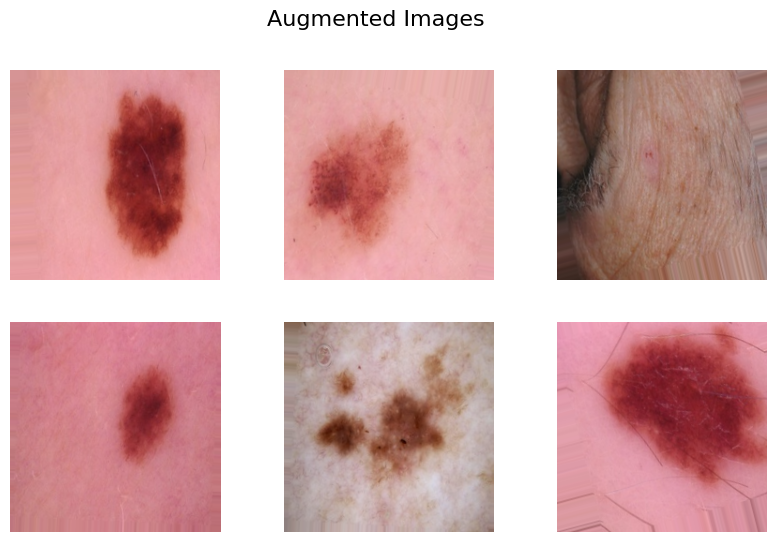

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of augmented images
imgs, labels = next(train_gen)

# Plot first 6 augmented images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


#### <font face="Verdana" color="green" size="+2">**1.4. Model Training (10 points)**




##### **1. Paper Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

paper_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:
paper_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

 = paper_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop],
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6280 - loss: 0.6311Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.7921 - loss: 0.4360 - val_accuracy: 0.7697 - val_loss: 0.4113
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.7900 - loss: 0.4168 - val_accuracy: 0.7727 - val_loss: 0.4167
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.8016 - loss: 0.3878 - val_accuracy: 0.8121 - val_loss: 0.4053
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.8040 - loss: 0.4034 - val_accuracy: 0.7818 - val_loss: 0.3991
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.8229 - loss: 0.3752 - val_accuracy: 0.8121 - val_loss: 0.3910
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.8225 - loss: 0.3689 - val_accuracy: 0.7879 - val_loss: 0.3926
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.8195 - loss: 0.3823 - val_accuracy: 0.8242 - val_loss: 0.3

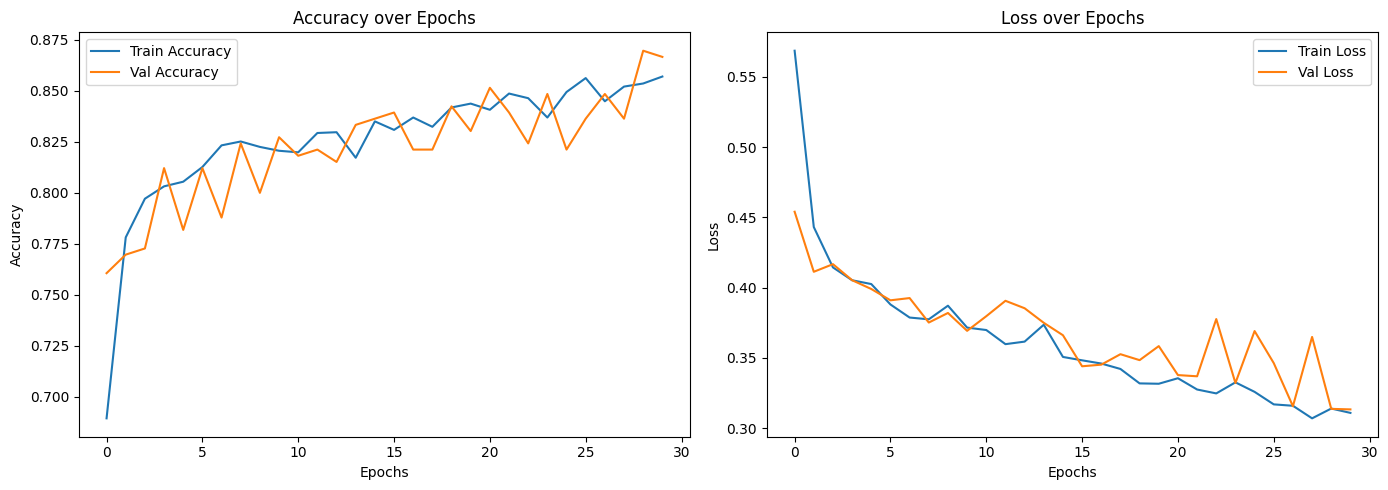

In [ ]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


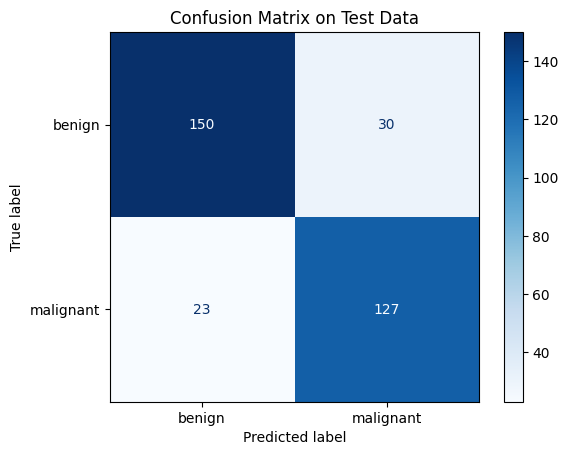

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred_probs = paper_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Data")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      benign       0.87      0.83      0.85       180
   malignant       0.81      0.85      0.83       150

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



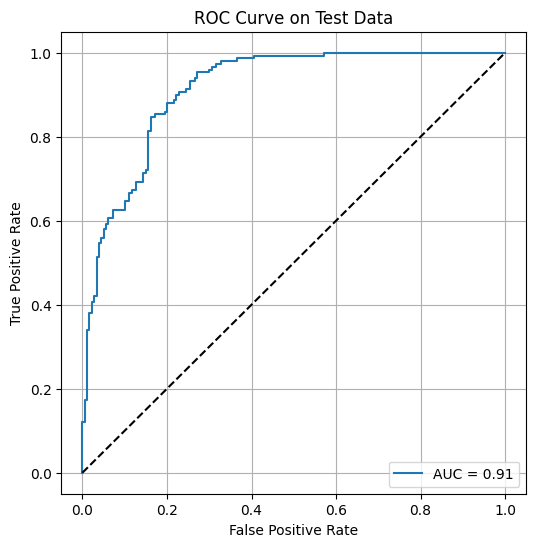

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##### **2. Custom Model**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

custom_model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary output
])

In [23]:
custom_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_2 = custom_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop]
)


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.7312 - loss: 0.5255 - val_accuracy: 0.5606 - val_loss: 1.0450
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.7644 - loss: 0.4889 - val_accuracy: 0.6606 - val_loss: 0.5974
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.7706 - loss: 0.4866 - val_accuracy: 0.7576 - val_loss: 0.5238
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.7974 - loss: 0.4301 - val_accuracy: 0.7576 - val_loss: 0.6191
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.7947 - loss: 0.4244 - val_accuracy: 0.5727 - val_loss: 0.6599
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.8031 - loss: 0.4096 - val_accuracy: 0.8333 - val_loss: 0.3533
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.8102 - loss: 0.4102 - val_accuracy: 0.8121 - val_loss: 0.3997
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 191ms/step - accuracy: 0.8221 - loss: 0


- **Batch Normalization** after Conv layers: stabilizes learning and accelerates convergence.
- **Dropout** layers after pooling and dense layers: combats overfitting.
- **Increased filters**: more capacity to learn complex features.

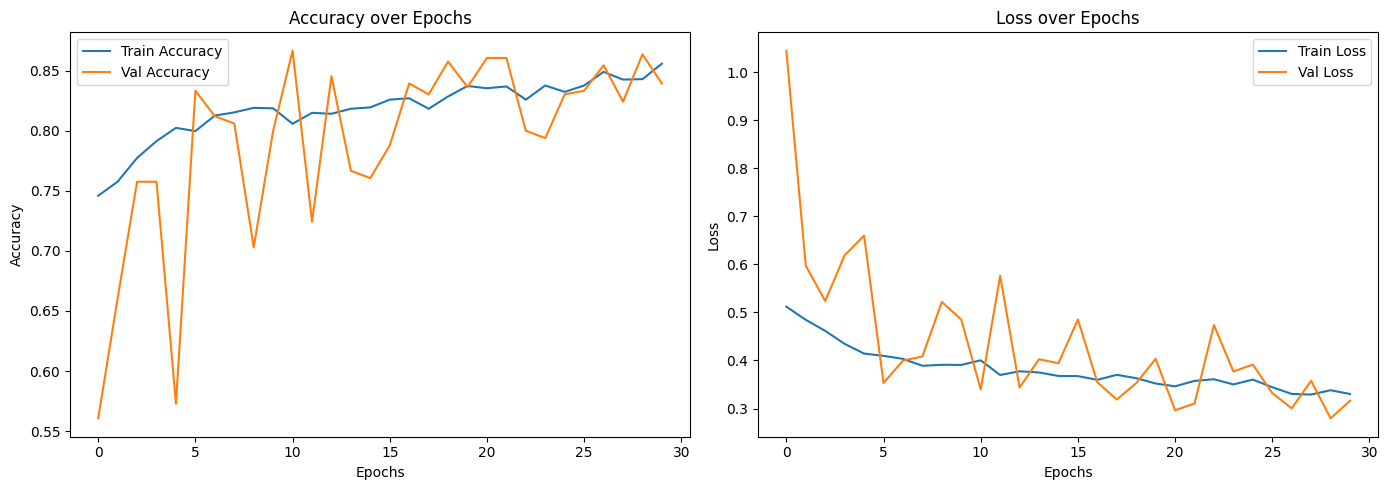

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_2)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


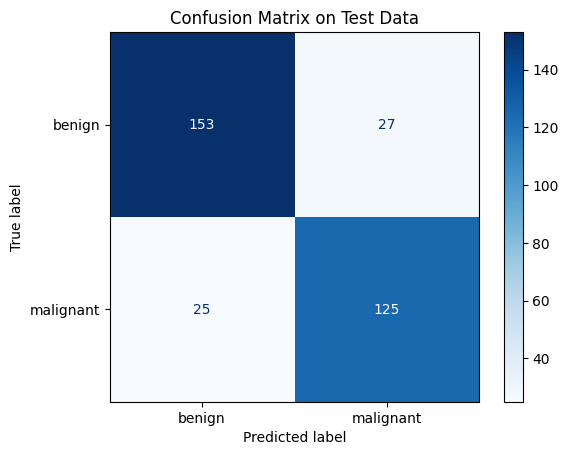

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred_probs = custom_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Data")
plt.show()


In [26]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      benign       0.86      0.85      0.85       180
   malignant       0.82      0.83      0.83       150

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



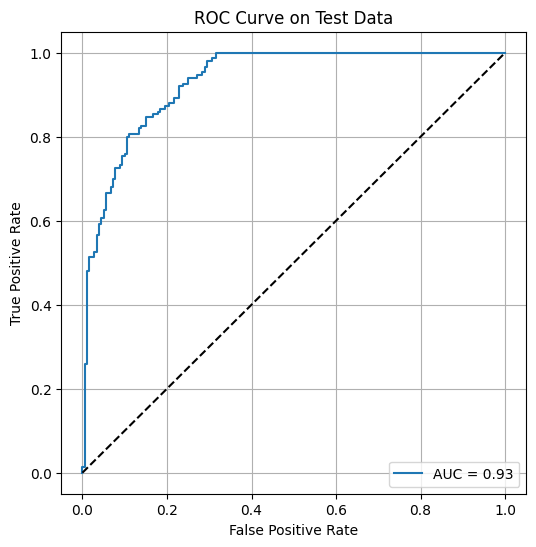

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##### **3. Optional Model**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

deep_model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

deep_model.compile(optimizer=Adam(),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_3 = deep_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 64s 296ms/step - accuracy: 0.6471 - loss: 9.7767 - val_accuracy: 0.4545 - val_loss: 2.5707
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.6735 - loss: 4.7562 - val_accuracy: 0.6970 - val_loss: 0.6068
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.6741 - loss: 2.2203 - val_accuracy: 0.5061 - val_loss: 0.6721
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.6640 - loss: 1.0747 - val_accuracy: 0.8000 - val_loss: 0.4705
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.7142 - loss: 0.6114 - val_accuracy: 0.7879 - val_loss: 0.4753
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.7311 - loss: 0.6192 - val_accuracy: 0.8152 - val_loss: 0.4506
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.7534 - loss: 0.5454 - val_accuracy: 0.7909 - val_loss: 0.5437
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.7660 - loss: 0

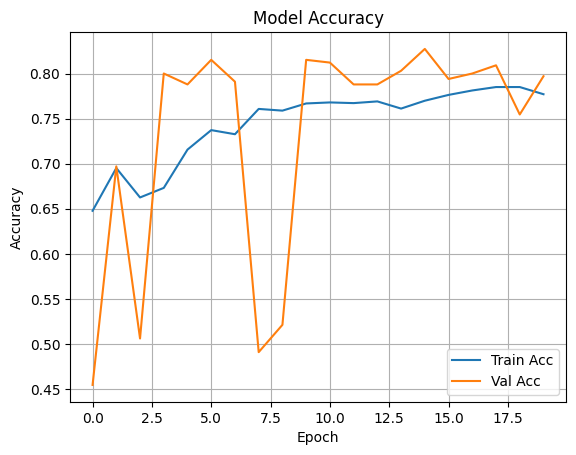

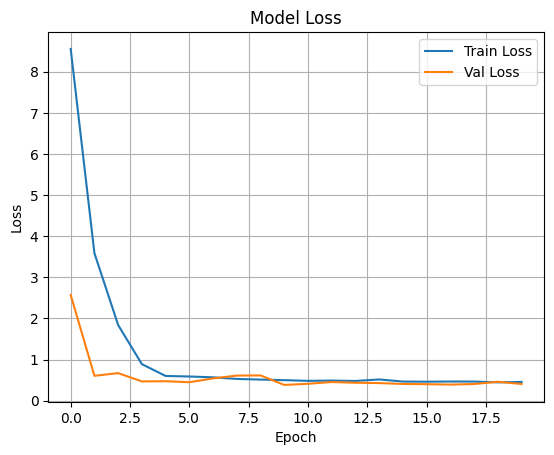

In [30]:
plt.plot(history_3.history['accuracy'], label='Train Acc')
plt.plot(history_3.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
              precision    recall  f1-score   support

     Class 0       0.94      0.61      0.74       180
     Class 1       0.67      0.95      0.79       150

    accuracy                           0.76       330
   macro avg       0.80      0.78      0.76       330
weighted avg       0.82      0.76      0.76       330

Confusion Matrix:
 [[109  71]
 [  7 143]]
ROC AUC Score: 0.9011111111111111


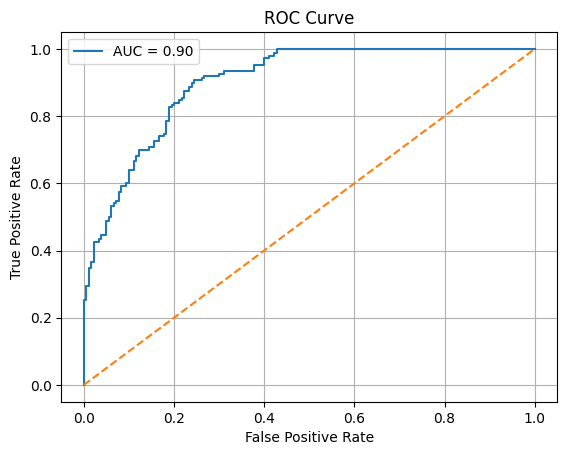

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred_probs = deep_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = test_gen.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# ROC AUC
roc_score = roc_auc_score(y_true, y_pred_probs)
print("ROC AUC Score:", roc_score)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr, label=f'AUC = {roc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


We designed a custom deep CNN architecture with Batch Normalization, Dropout, and multiple stacked Conv layers. it did not outperform the original model.

The validation loss remained high, indicating the model produced overconfident but incorrect predictions. Likely causes include overparameterization, limited data, and excessive depth.

We conclude that while deeper models are powerful, they are not always optimal for small/medium datasets. The original model strikes a better balance between complexity and generalization.

##### **3. Imbalance Handling**

In [ ]:
import os

train_dir = 'skin_cancer_split/train'
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

print(class_counts)


{'malignant': 1197, 'benign': 1440}


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Match class order from generator
class_indices = train_gen.class_indices  # e.g., {'benign': 0, 'malignant': 1}
print("Class indices:", class_indices)

# Create label list
labels = []
for class_name, index in class_indices.items():
    labels.extend([index] * class_counts[class_name])

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class indices: {'benign': 0, 'malignant': 1}
Class weights: {0: np.float64(0.915625), 1: np.float64(1.1015037593984962)}


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_imb = paper_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]  # optional
)


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - accuracy: 0.8423 - loss: 0.3148 - val_accuracy: 0.8667 - val_loss: 0.3150
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.8552 - loss: 0.2916 - val_accuracy: 0.8303 - val_loss: 0.3385
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.8631 - loss: 0.2811 - val_accuracy: 0.8545 - val_loss: 0.3208
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.8576 - loss: 0.3018 - val_accuracy: 0.8424 - val_loss: 0.3296
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8698 - loss: 0.2751 - val_accuracy: 0.8485 - val_loss: 0.3170
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.8726 - loss: 0.2740 - val_accuracy: 0.8848 - val_loss: 0.3015
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.8460 - loss: 0.3106 - val_accuracy: 0.8515 - val_loss: 0.3190
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.8610 - loss: 0

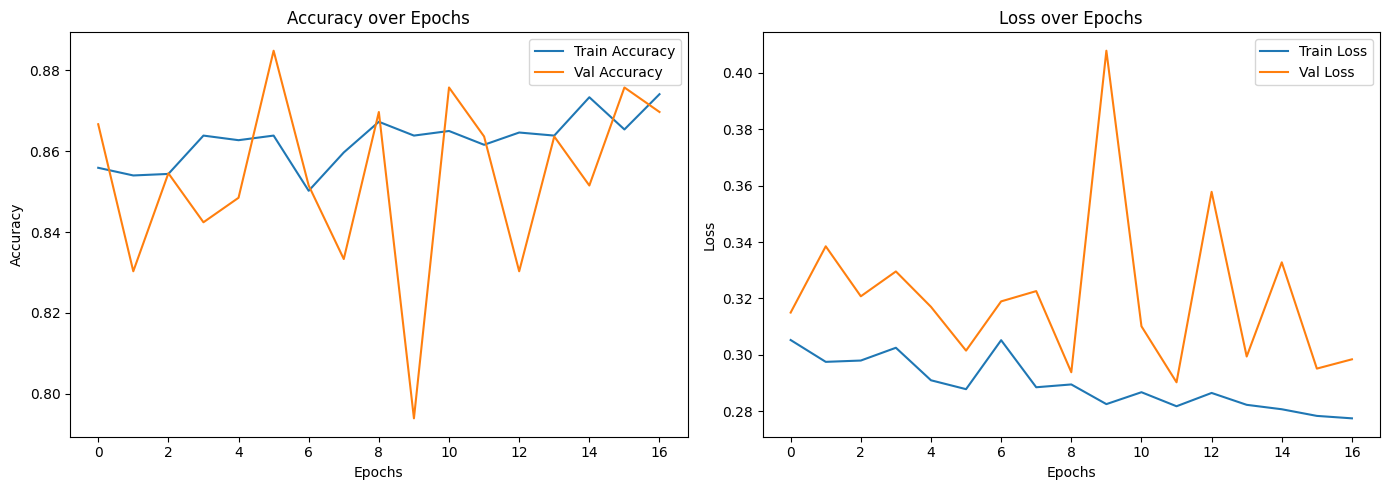

In [ ]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_imb)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


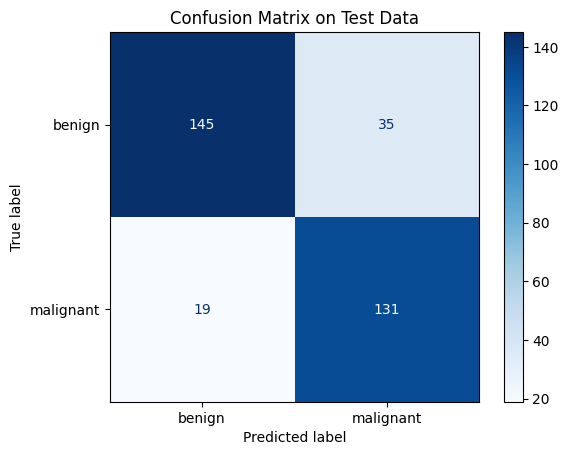

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred_probs = paper_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Data")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.81      0.84       180
   malignant       0.79      0.87      0.83       150

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



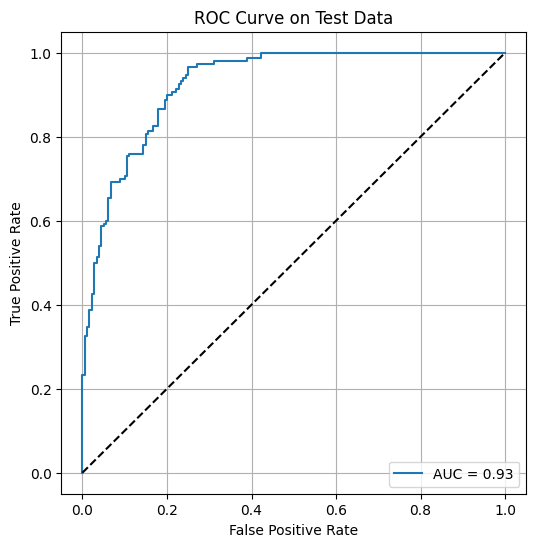

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
